In [4]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt

from eda_utils import display_img_with_mask

In [5]:
centered_df = pd.read_csv('centered_instances.csv', index_col=0)
centered_df

,ImageId,ClassId,instance_center_x,window_size
0,ac4ba5c1a.jpg,3,1227.626435,150
1,ac4ba5c1a.jpg,3,1378.553672,150
2,ac4ba5c1a.jpg,3,1358.213191,150
3,ac4ba5c1a.jpg,3,1353.812325,150
4,ac4ba5c1a.jpg,3,1389.486034,150
...,...,...,...,...
148,4ef21d9b7.jpg,3,598.410367,150
149,97bf2a97c.jpg,1,70.753304,150
150,97bf2a97c.jpg,1,933.511327,150
151,97bf2a97c.jpg,1,1202.360695,150


In [9]:
def overlaps_edge(row):
    hw = row.window_size // 2
    extra = row.window_size % 2
    min_x, max_x = row.instance_center_x - hw, row.instance_center_x + hw + extra
    return (min_x < 0) or (max_x > 1600)

centered_df['overlaps_edge'] = centered_df.apply(overlaps_edge, axis=1)
display(centered_df.groupby(by=['ClassId', 'overlaps_edge']).size())
centered_df

ClassId  overlaps_edge
1        False            14
         True              3
3        False            96
         True              3
dtype: int64

,ImageId,ClassId,instance_center_x,window_size,overlaps_edge
0,ac4ba5c1a.jpg,3,1227.626435,150,False
1,ac4ba5c1a.jpg,3,1378.553672,150,False
2,ac4ba5c1a.jpg,3,1358.213191,150,False
3,ac4ba5c1a.jpg,3,1353.812325,150,False
4,ac4ba5c1a.jpg,3,1389.486034,150,False
...,...,...,...,...,...
148,4ef21d9b7.jpg,3,598.410367,150,False
149,97bf2a97c.jpg,1,70.753304,150,True
150,97bf2a97c.jpg,1,933.511327,150,False
151,97bf2a97c.jpg,1,1202.360695,150,False


CPU times: user 1 s, sys: 323 ms, total: 1.33 s
Wall time: 832 ms


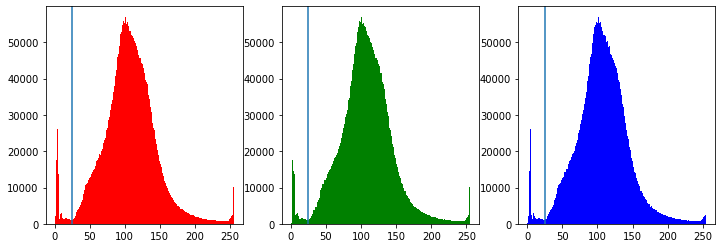

In [55]:
%%time

images = []

for row in centered_df.itertuples():
    img = plt.imread(os.path.join('..', 'data', 'train_images', row.ImageId))
    hw = row.window_size // 2
    extra = row.window_size % 2
    min_x, max_x = int(row.instance_center_x - hw), int(row.instance_center_x + hw + extra)
    img = img[:, min_x:max_x]
    images.append(img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (ax, color) in enumerate(zip(axes.flat, ['red', 'green', 'blue'])):
    ax.hist(np.concatenate([np.ravel(img[:, :, i]) for img in images]),
            label=color, color=color, bins=256)
    ax.axvline(x=25)

## Discussion

Looking at the pixel values for all subregions we're considering, we can see a few things:
* RGB channels are nearly identical
* There is a peak near zero
* The "big peak" starts around value 25 (indicated by the vertical line)

This suggests the following heuristic: if the mean pixel values are less than ~25, we'll consider a region to be "blank"

In [60]:
%%time

def has_blank_space(row, tol=25):
    """
    The heuristic for detecting blank space is if one of the image columns is close to zero.
    If the mean of all pixel vals is less than tol, we say it's close to zero.
    """
    img = plt.imread(os.path.join('..', 'data', 'train_images', row.ImageId))
    hw = row.window_size // 2
    extra = row.window_size % 2
    min_x, max_x = int(row.instance_center_x - hw), int(row.instance_center_x + hw + extra)
    img = img[:, min_x:max_x]
    return np.any([np.mean(col) < tol for col in np.moveaxis(img, 0, -1)])

centered_df['has_blank_space'] = centered_df.apply(has_blank_space, axis=1)
display(centered_df.has_blank_space.value_counts())

False    103
True      13
Name: has_blank_space, dtype: int64

CPU times: user 543 ms, sys: 8.4 ms, total: 551 ms
Wall time: 550 ms


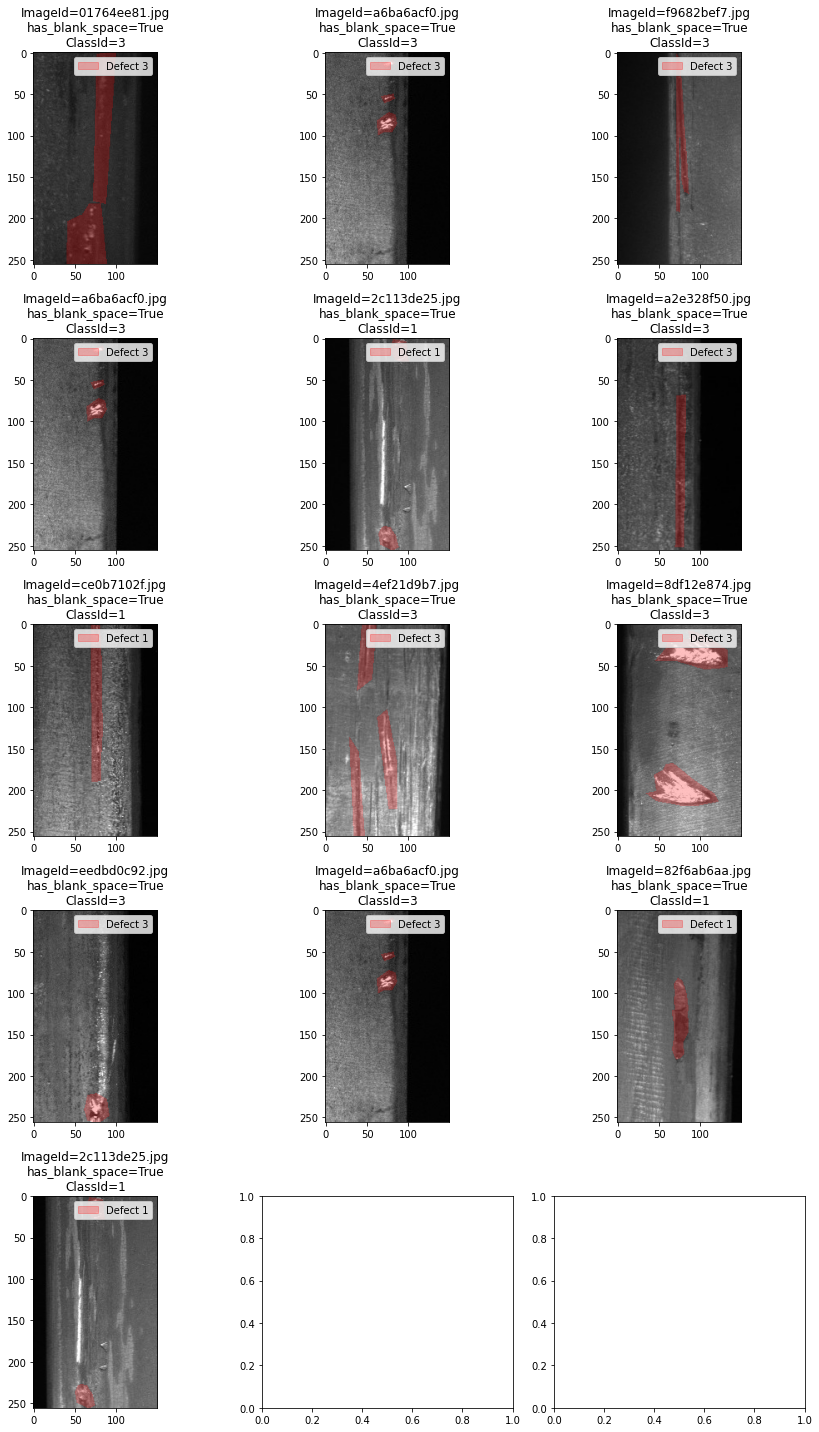

In [61]:
nrows = 5
fig, axes = plt.subplots(nrows, 3, figsize=(12, 4 * nrows))

train_df = pd.read_csv('../data/train.csv')
mask = centered_df.has_blank_space == True
for ax, row in zip(axes.flat, centered_df[mask].sample(frac=1, random_state=42).itertuples()):
    ax.set_title(f'ImageId={row.ImageId}\nhas_blank_space=True\nClassId={row.ClassId}')
    hw = row.window_size // 2
    x_min, x_max = int(row.instance_center_x - hw), int(row.instance_center_x + hw)
    if x_min < 0:
        print(f'x_min={x_min} is off the edge, setting to 0')
        x_min = 0
    if x_max > 1600:
        print(f'x_max={x_max} is off the edge, setting to 1600')
        x_max = 1600
    display_img_with_mask(train_df, row.ImageId, 
                          x_window=(x_min, x_max), 
                          ax=ax)

plt.tight_layout()

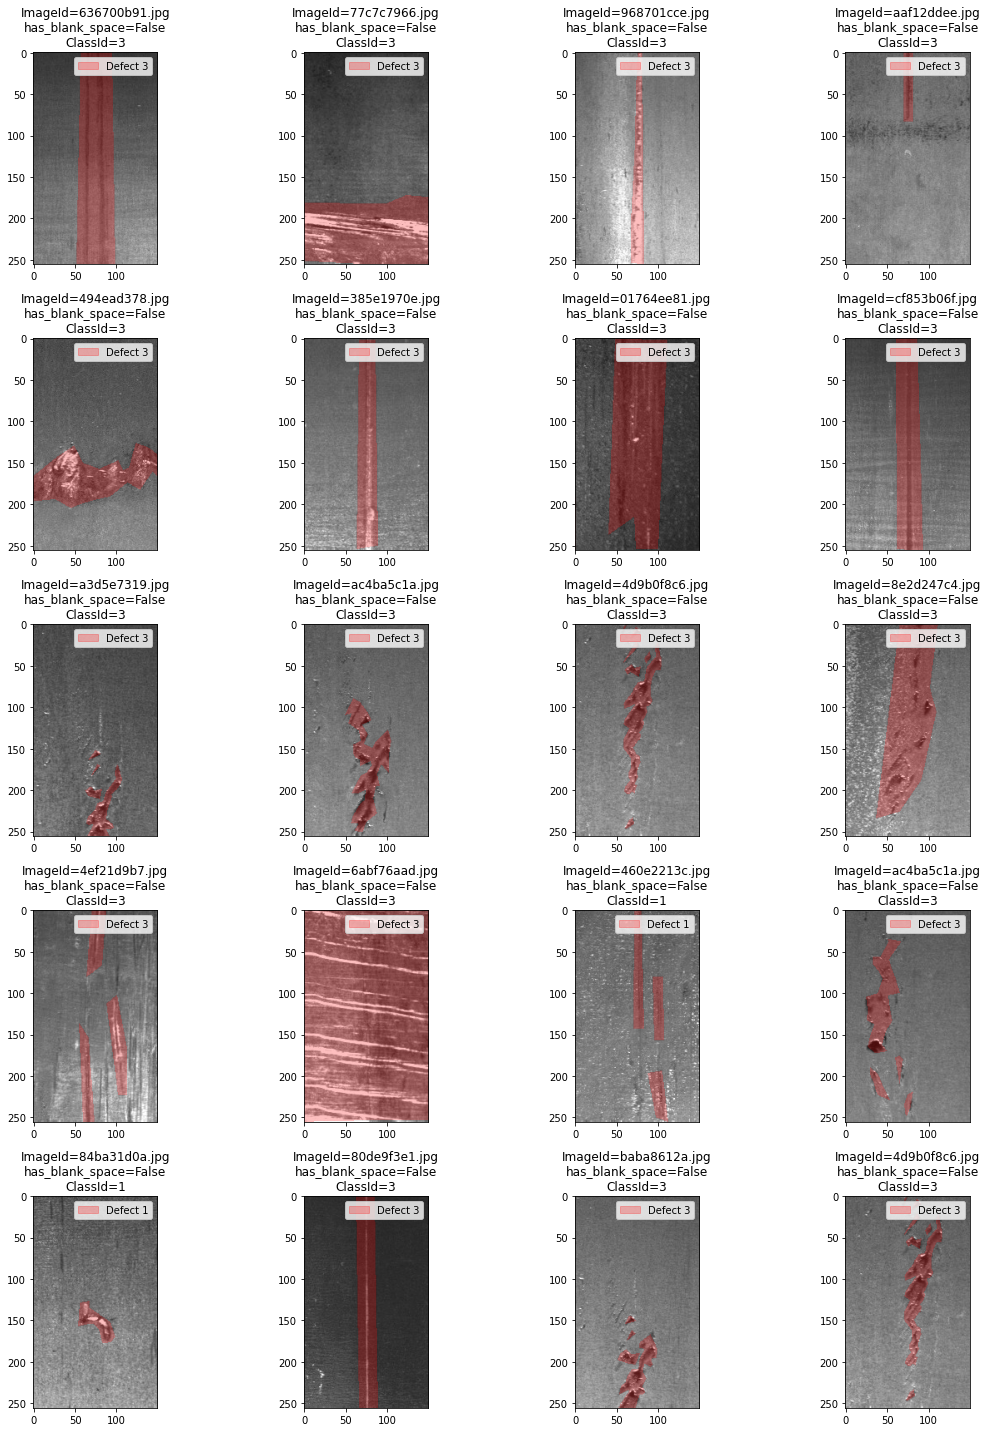

In [63]:
nrows = 5
fig, axes = plt.subplots(nrows, 4, figsize=(16, 4 * nrows))

train_df = pd.read_csv('../data/train.csv')
mask = centered_df.has_blank_space == False
for ax, row in zip(axes.flat, centered_df[mask].sample(frac=1, random_state=42).itertuples()):
    ax.set_title(f'ImageId={row.ImageId}\nhas_blank_space=False\nClassId={row.ClassId}')
    hw = row.window_size // 2
    x_min, x_max = int(row.instance_center_x - hw), int(row.instance_center_x + hw)
    if x_min < 0:
        print(f'x_min={x_min} is off the edge, setting to 0')
        x_min = 0
    if x_max > 1600:
        print(f'x_max={x_max} is off the edge, setting to 1600')
        x_max = 1600
    display_img_with_mask(train_df, row.ImageId, 
                          x_window=(x_min, x_max), 
                          ax=ax)

plt.tight_layout()